In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display

In [30]:
PROJECT_ROOT = Path.cwd().parent

# Define the file path relative to the PROJECT_ROOT
DATA_PATH = PROJECT_ROOT / "Data" / "train-00000-of-00001.parquet"

In [31]:
# --- Corrected load_and_preprocess_data function ---

def load_and_preprocess_data(path):
    """Loads the Parquet file, explodes list-columns, and sets the DatetimeIndex."""
    try:
        df = pd.read_parquet(path)
    except Exception as e:
        print(f"Error reading Parquet file: {e}")
        return None

    # Columns to explode - all of them except 'id' (and the initial index)
    # Note: Using .drop() on columns that are lists for the explosion
    cols_to_explode = [col for col in df.columns if col not in ['id']]

    # Explode all list-like columns into long format
    df_long = df.explode(cols_to_explode)

    # Convert the new 'timestamp' column to the proper datetime object and set it as the index
    # This replaces the original index
    df_long['timestamp'] = pd.to_datetime(df_long['timestamp'])
    display(df_long['timestamp'].head(3))
    df_long = df_long.set_index('timestamp').sort_index()
    
    # === REMOVE THIS LINE ===
    # df_long = df_long.droplevel(0) 
    
    # --- Time Series Specific Clean-up ---
    # Convert 'id' (country code) to a categorical type for XGBoost
    df_long['id'] = df_long['id'].astype('category')
    
    # Convert all remaining float columns to numeric
    for col in df_long.columns.drop('id'):
        df_long[col] = pd.to_numeric(df_long[col], errors='coerce')

    print("\n--- Exploded Time Series Data (Top 3 Rows) ---")
    print(df_long.head(3).to_markdown())
    print("---------------------------------------------")
    
    return df_long

After conversion adn explode:

The structure is common for datasets that combine multiple independent time series into a single DataFrame.

**Underlying Frequency**: The data was collected every 15 minutes (e.g., 00:15, 00:30, 00:45, 01:00, and so on). This is the correct step size.

**Multivariate Structure**:** After the **explode() function**, the single row for all countries at time $t$ was transformed into multiple rows—one row for each country (id) at that same time $t$.

"The explode() method transforms each element of a list-like column into a separate row, while duplicating the other column values."     
The index is repeated because your dataset is multivariate and multi-country.

In [42]:

if __name__ == "__main__":
    
    # This part should be run in your notebook first for inspection
    df_original = load_and_preprocess_data(DATA_PATH)
    if df_original is not None:
        print(f"Data successfully transformed. Total rows: {len(df_original)}")
        # Check for missing values (NaNs) after conversion
        print("\nMissing values per column:")
        print(df_original.isnull().sum())


0   2015-01-01 00:15:00
0   2015-01-01 00:30:00
0   2015-01-01 00:45:00
Name: timestamp, dtype: datetime64[ns]


--- Exploded Time Series Data (Top 3 Rows) ---
| timestamp           | id   |   target |   solar_generation_actual |   wind_onshore_generation_actual |   temperature |   radiation_direct_horizontal |   radiation_diffuse_horizontal |
|:--------------------|:-----|---------:|--------------------------:|---------------------------------:|--------------:|------------------------------:|-------------------------------:|
| 2015-01-01 00:15:00 | AT   |   5966.8 |                      1.16 |                            69.96 |        -6.458 |                             0 |                              0 |
| 2015-01-01 00:15:00 | DE   |  41517.7 |                     14.18 |                          8301.32 |        -1.035 |                             0 |                              0 |
| 2015-01-01 00:15:00 | NL   |   9524   |                     17    |                          1302.48 |         1.625 |                             0 |                              0 |
----------------------

### Missing data

Strategy: Zero or Forward Fill (FFill): For electricity generation data, missing actual values often mean there was zero generation or the sensor was down. A robust approach is:

Impute Zeros: If missing data genuinely means zero generation.

Forward Fill (ffill): If the value likely hasn't changed since the last known measurement (this is more common for slowly changing sensor readings). Since this data is 15-minute, forward fill is safer than assuming zero.

In [43]:
# 1. This is necessary to apply ffill country-by-country without leakage.
df_with_id_index = df_original.set_index('id', append=True) 

# 2. Apply FFill within each country group ('id')
df_imputed = df_with_id_index.groupby(level='id').ffill()

# 3. Bring 'id' back as a regular column, maintaining the 'timestamp' index
# We reset the 'id' level, but keep the 'timestamp' index.
df_imputed = df_imputed.reset_index(level='id') 

# 4. Separate the 'id' column before filling NaNs because it has categorical values like names.
# We apply the fillna(0) ONLY to the remaining numeric columns.
numeric_cols = df_imputed.select_dtypes(include=['number']).columns 

# Apply fillna(0) only to the numeric columns
df_imputed[numeric_cols] = df_imputed[numeric_cols].fillna(0)

C:\Users\Ali\AppData\Local\Temp\ipykernel_28220\1321474335.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_imputed = df_with_id_index.groupby(level='id').ffill()


In [44]:
df_imputed.head(3)

,id,target,solar_generation_actual,wind_onshore_generation_actual,temperature,radiation_direct_horizontal,radiation_diffuse_horizontal
timestamp,,,,,,,
2015-01-01 00:15:00,AT,5966.799805,1.16,69.959999,-6.458,0.0,0.0
2015-01-01 00:15:00,DE,41517.718750,14.18,8301.320312,-1.035,0.0,0.0
2015-01-01 00:15:00,NL,9524.000000,17.00,1302.479980,1.625,0.0,0.0


In [45]:
df_imputed.isnull().sum()

id                                0
target                            0
solar_generation_actual           0
wind_onshore_generation_actual    0
temperature                       0
radiation_direct_horizontal       0
radiation_diffuse_horizontal      0
dtype: int64

### Temporal Features (Exogenous Variables)

These features are derived from the timestamp index and help XGBoost understand the cyclical nature of energy load.

For your ENTSO-e Load (15T) data, which is 15-minute frequency, the key features you should encode are Hour and Day of Week:
```
Hour:  	        24	The cycle repeats every 24 hours.                           $sin(2\pi \cdot \frac{Hour}{24})$ and $cos(2\pi \cdot \frac{Hour}{24})$
Day of Week:	7	The cycle repeats every 7 days (Monday to Sunday).          $sin(2\pi \cdot \frac{DayofWeek}{7})$ and $cos(2\pi \cdot \frac{DayofWeek}{7})$
Month:          12  The cycle repears every 12 months
```

In [46]:
df_feat = df_imputed.copy()
# Extract temporal features from the DatetimeIndex
df_feat["hour"] = df_feat.index.hour
df_feat["quarter"] = df_feat.index.quarter
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["dayofyear"] = df_feat.index.dayofyear
df_feat["weekofyear"] = df_feat.index.isocalendar().week
df_feat["month"] = df_feat.index.month
df_feat["quarter_start"] = df_feat.index.is_quarter_start.astype(int)
df_feat["is_weekend"] = (df_feat.index.dayofweek >= 5).astype(int)

df_feat[["hour", "quarter", "dayofweek", "dayofyear"]].head(3)

# Apply the transformations to the features created in the previous step (df_feat) to avoid integer problems for model

# 1. Hour Encoding (Period P = 24)
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

# 2. Day of Week Encoding (Period P = 7)
df_feat["dayofweek_sin"] = np.sin(2 * np.pi * df_feat["dayofweek"] / 7)
df_feat["dayofweek_cos"] = np.cos(2 * np.pi * df_feat["dayofweek"] / 7)

# 3. Month Encoding (Period P = 12) - Recommended Addition
df_feat["month_sin"] = np.sin(2 * np.pi * df_feat["month"] / 7)
df_feat["month_cos"] = np.cos(2 * np.pi * df_feat["month"] / 7)

# Drop the original integer features to avoid redundancy/confusion
df_feat = df_feat.drop(columns = ["hour", "dayofweek", "month"])

In [47]:
df_feat[["hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos"]].head(8)

,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
timestamp,,,,,,
2015-01-01 00:15:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:30:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:30:00,0.0,1.0,0.433884,-0.900969,0.781831,0.62349


## Lagged Features 

### Step 1: Create Lagged Features

This step incorporates the history of the target variable (target load) into the current row, which is essential for any non-temporal model like XGBoost to forecast. We must use groupby('id') to ensure you only lag within the same country (out of 6 countries)  to prevent data leakage.


```
Lag Steps,          Time Period,                Reasoning
1,                  15 minutes ago,         Most recent load observation.
4,                  1 hour ago,             Captures short-term hourly seasonality.
96,                 1 day ago,              Daily seasonality (24 hours × 4 steps/hour).
672,                1 week ago,             Weekly seasonality (7 days × 96 steps/day).
```


In [51]:
df_feat.groupby("id").head(1)

C:\Users\Ali\AppData\Local\Temp\ipykernel_28220\4255111429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat.groupby("id").head(1)


,id,target,solar_generation_actual,wind_onshore_generation_actual,temperature,radiation_direct_horizontal,radiation_diffuse_horizontal,quarter,dayofyear,weekofyear,quarter_start,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,
2015-01-01 00:15:00,AT,5966.799805,1.16,69.959999,-6.458,0.0,0.0,1,1,1,1,0,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,DE,41517.718750,14.18,8301.320312,-1.035,0.0,0.0,1,1,1,1,0,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,NL,9524.000000,17.00,1302.479980,1.625,0.0,0.0,1,1,1,1,0,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,LU,407.000000,0.00,0.000000,-2.083,0.0,0.0,1,1,1,1,0,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,HU,4106.200195,0.31,12.220000,-8.358,0.0,0.0,1,1,1,1,0,0.0,1.0,0.433884,-0.900969,0.781831,0.62349
2015-01-01 00:15:00,BE,9575.730469,0.00,0.000000,-0.302,0.0,0.0,1,1,1,1,0,0.0,1.0,0.433884,-0.900969,0.781831,0.62349


In [52]:
# ----------------------------------------------------
# 1. Feature Engineering: Lagged Features (using df_imputed from above)
# ----------------------------------------------------
target_col = "target"

# Define lags in 15-minute steps: 15min, 1hr, 1 day, 1 week
lags = [1, 4, 96, 672]  # Corresponding to 15min, 1hr, 1 day, 1 week

print("--- Creating Lagged Features ---")
for lag in lags:
    # CRITICAL: Apply the shift operation group-wise (by country 'id', there are 6 countries)
    df_feat[f"{target_col}_lag_{lag}"] = df_feat.groupby("id")[target_col].shift(lag)
print(f"Lag features created: {lags}")

--- Creating Lagged Features ---
Lag features created: [1, 4, 96, 672]


C:\Users\Ali\AppData\Local\Temp\ipykernel_28220\2446504877.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat[f"{target_col}_lag_{lag}"] = df_feat.groupby("id")[target_col].shift(lag)
C:\Users\Ali\AppData\Local\Temp\ipykernel_28220\2446504877.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat[f"{target_col}_lag_{lag}"] = df_feat.groupby("id")[target_col].shift(lag)
C:\Users\Ali\AppData\Local\Temp\ipykernel_28220\2446504877.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

### Step 2: Final Cleaning and Encoding

Before the split, we perform the final cleanup, which includes handling the new NaN rows created by the lags and encoding the categorical features.

Comment: For XGBoost / Trees: we CAN use Label Encoding (Integers). Tree models are smart enough to split data like "Is Country Code < 1.5, but for NN or regression, we should use One Hot endcoing.

In [58]:
df_energy = df_feat.copy()

# A. Encoding the 'id' (Country)
# We convert the column to 'category' type, then extract the underlying integer codes. This maps AT->0, BE->1, etc.
df_energy["id_encoded"] = df_energy["id"].astype("category").cat.codes

# B. Drop the original string 'id' column. XGBoost requires all input features to be numeric.
df_energy = df_energy.drop(columns = ["id"])

# C. Handling Missing Values created by Lags
# The shifting operation created NaNs in the first 672 rows of each country. We drop these rows to have a clean dataset for training.
df_energy = df_energy.dropna()

# 4. Separate Target (y) and Features (X)
X = df_energy.drop(columns=[target_col])
y = df_energy[target_col]

print("\n--- Final Data Check ---")
print(f"Total rows after dropping NaNs: {len(df_energy)}")
print(f"Shape of Features (X): {X.shape}")
print(f"Shape of Target (y): {y.shape}")


--- Final Data Check ---
Total rows after dropping NaNs: 1047720
Shape of Features (X): (1047720, 21)
Shape of Target (y): (1047720,)


In [59]:
X.head(3)

,solar_generation_actual,wind_onshore_generation_actual,temperature,radiation_direct_horizontal,radiation_diffuse_horizontal,quarter,dayofyear,weekofyear,quarter_start,is_weekend,...,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,target_lag_1,target_lag_4,target_lag_96,target_lag_672,id_encoded
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-08 00:15:00,0.00,2354.709961,2.153,0.0,0.0,1,8,2,0,0,...,1.0,0.433884,-0.900969,0.781831,0.62349,9525.000000,10094.000000,8983.320312,9524.000000,5
2015-01-08 00:15:00,0.00,0.000000,1.499,0.0,0.0,1,8,2,0,0,...,1.0,0.433884,-0.900969,0.781831,0.62349,10793.110352,11090.309570,10519.669922,9575.730469,1
2015-01-08 00:15:00,0.31,10.340000,-7.428,0.0,0.0,1,8,2,0,0,...,1.0,0.433884,-0.900969,0.781831,0.62349,4537.580078,4696.859863,4369.569824,4106.200195,3


### Step 3: Train/Test Split (Time Series Style)

For time series, you cannot use a random split. You must use a temporal split, where the training data is before a certain date, and the test data is after it.

A common MLOps practice is to reserve the last period of data for validation. Given your total dataset size (1047720 rows), reserving the last 20% or a few weeks of data for testing is reasonable.

In [60]:
# Define the split point by index (e.g., last 20% of data)

split_point = int(len(X) * 0.8) # 80% for training, 20% for testing

#Split the data temporally
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"\n--- Temporal Split ---")
print(f"X_train size: {len(X_train)} rows")
print(f"X_test size: {len(X_test)} rows")
print(f"Test data starts at timestamp: {X_test.index.min().strftime('%Y-%m-%d %H:%M')}")


--- Temporal Split ---
X_train size: 838176 rows
X_test size: 209544 rows
Test data starts at timestamp: 2019-01-02 04:15


## Creating the Training Pipeline

Since X_train is already fully numeric and has no missing values, we don't strictly need a complex ColumnTransformer to impute or encode (you did that already!).

We will create a pipeline that:

(Optionally) Scales the data.

Runs the XGBoost Regressor.

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Define the Pipeline ---
# We use a Pipeline to bundle preprocessing (scaling) with the model. Even though XGBoost is tree-based and handles unscaled data well, 
# keeping the pipeline structure is best practice for MLOps.

pipeline = Pipeline([
    ("scaler", StandardScaler()), # Optional: scales features to unit variance
    ("model", XGBRegressor(
        n_estimators=1000,               # Number of trees
        learning_rate=0.1,              # Step size shrinkage
        max_depth=7,                    # Depth of trees
        objective='reg:squarederror',   # Crucial for Regression
        random_state=42,
        n_jobs=-1                       # Use all CPUs
                        ))
                    ])

# --- Train the Model ---
print("Training XGBoost Pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")

Training XGBoost Pipeline...
Training complete.


### Hyperparameter Tunning

In [72]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_grid = {
    'model__n_estimators': [100, 500, 1000],    # More trees = better fit but slower
    'model__max_depth': [3, 5, 7, 10],          # Deeper = more complex patterns
    'model__learning_rate': [0.01, 0.1, 0.3],   # Lower requires more trees
    'model__subsample': [0.7, 0.8, 1.0],        # Fraction of rows per tree
    'model__colsample_bytree': [0.7, 0.8, 1.0]  # Fraction of columns per tree
}

# Create the search object (optimize for Negative MAE)
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_grid, 
    n_iter=10,              # Try 10 random combinations
    scoring='neg_mean_absolute_error', 
    cv=3,                   # 3-fold cross-validation
    verbose=1, 
    n_jobs=-1
)

# Fit the search (This will take longer than 1 minute!)
search.fit(X_train, y_train)

print("Best Parameters:", search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__subsample': 1.0, 'model__n_estimators': 1000, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}


## Evaluating the Model

we calculate MAE (how far off was I in MegaWatts?) and R2 Score (how well does the model fit the data compared to a flat line?)

In [74]:
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions
predictions = pipeline.predict(X_test)

# Calculate Regression Metrics
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print them out (Logic: Lower MAE is better, Higher R2 is better)
print("Mean absolute error :", round(mae, 2), "MW")
print("R2 Score:", round(r2, 2))

Mean absolute error : 92.33 MW
R2 Score: 1.0


### Create the Metrics File

We save these numbers to the text file, just changing the variable names.

In [75]:
with open(PROJECT_ROOT/"Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nMean Absolute Error = {round(mae, 2)}, R2 Score = {round(r2, 2)}.")

### Plot (Actual vs. Predicted)

The standard "proof" of a time series model is a line plot showing the Forecast vs. Actual values.

We will plot just the first few days (e.g., 100 data points) so the chart is readable in the saved image.

Plot saved to Results/model_results.png


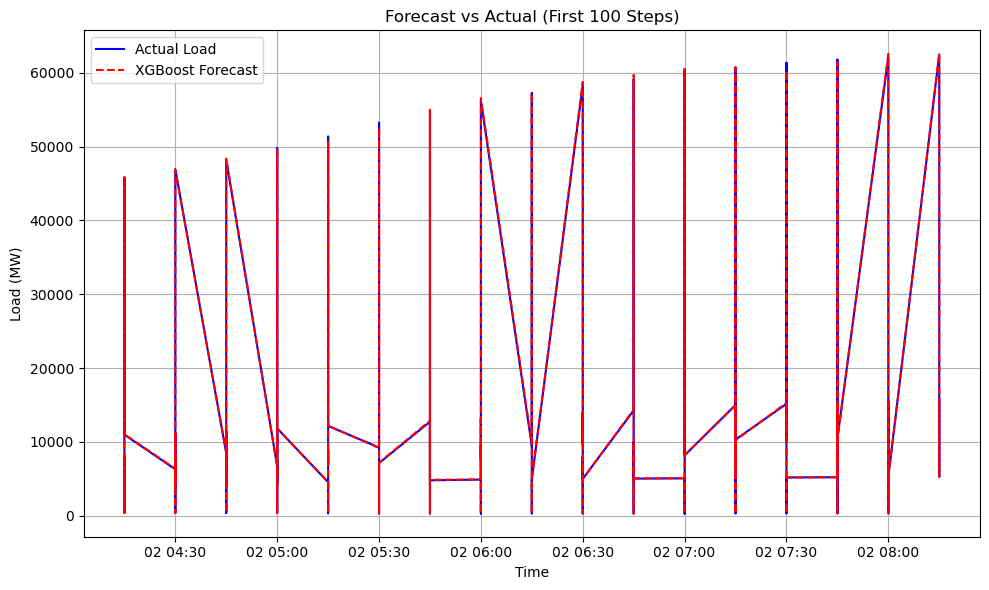

In [76]:
import matplotlib.pyplot as plt

# Create a plot of the first 100 hours/steps to make it readable
plt.figure(figsize=(10, 6))

# Plot Actuals
plt.plot(y_test.index[:100], y_test.iloc[:100], label='Actual Load', color='blue')

# Plot Predictions
plt.plot(y_test.index[:100], predictions[:100], label='XGBoost Forecast', color='red', linestyle='--')

plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.title("Forecast vs Actual (First 100 Steps)")
plt.legend()
plt.grid(True)

# Save the plot to the Results folder
plt.tight_layout()
plt.savefig(PROJECT_ROOT/"Results/model_results.png", dpi=120)
print("Plot saved to Results/model_results.png")